# Transmon Floquet analysis

In this initial demo we perform the Floquet analysis on a transmon with a readout frequency above the qubit frequency, mapping the probability of ionization as a function of drive strength and drive frequency. We then compare these simulations to Blais-style branch crossing plots, which identify the states the qubit states leak to.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = cycler(plt.rcParams["axes.prop_cycle"])
ls_cycler = cycler(ls=["-", "--", "-.", ":"])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

## Transmon with readout resonator above the qubit frequency

In [31]:
filepath = ft.generate_file_path("h5py", "transmon_floquet", "out")

EC = 0.22
EJ = 0.22 * 110
E_osc = 7.50 # negative detuning from the transmon frequency in GHz
E_osc = 5.3 # positive

# Transmon parameters
num_states = 20
# These parameters give a transmon with E10 = 5.45 GHz, alpha = -219 MHz
qubit_params = {"EJ": EJ, "EC": EC, "ng": 0.0, "ncut": 41}
tmon = scq.Transmon(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]  # get data for ground and first excited states


# Express operators in eigenbasis of transmon
def get_H0_H1(qubit_instance: scq.GenericQubit) -> tuple[qt.Qobj, qt.Qobj]:
    hilbert_space = scq.HilbertSpace([qubit_instance])
    hilbert_space.generate_lookup()
    evals = hilbert_space["evals"][0][0:num_states]
    H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
    H1 = hilbert_space.op_in_dressed_eigenbasis(qubit_instance.n_operator)
    return H0, H1


H0, H1 = get_H0_H1(tmon)

# Drive parameters
# Drive frequencies to scan over
omega_d_values = 2.0 * np.pi * np.linspace(E_osc, 10.0, 1)
# Induced ac stark shifts to scan over
chi_ac_values = 2.0 * np.pi * np.linspace(0.0, 2, 200)
# To achieve same range of chi_ac for the various drive frequencies, need different
# drive amplitudes. This utility computes the linear drive strength required to achieve
# a desired induced ac-Stark shift for the various drive frequencies.
chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_values)
# drive_amplitudes has shape (a,w), where a is amplitude and w is frequency
drive_amplitudes = chi_to_amp.amplitudes_for_omega_d(chi_ac_values)

# initialize the model to pass to FloquetAnalysis
model = ft.Model(
    H0, H1, omega_d_values=omega_d_values, drive_amplitudes=drive_amplitudes
)

options = ft.Options(
    fit_range_fraction=0.5,  # split the fit into segments based on this fraction
    floquet_sampling_time_fraction=0.0,  # fraction of the period to compute the Floquet modes  # noqa E501
    fit_cutoff=4,  # polynomial cutoff
    overlap_cutoff=0.8,  # cutoff for excluding from the fit
    nsteps=30_000,  # qutip integration parameter
    num_cpus=6,  # number of cpus to use to compute Floquet modes in parallel
    save_floquet_modes=True,  # whether or not to save floquet modes themselves
)

 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: overflow encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: invalid value encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199

### Calculating $\chi$ from the paper parameters

### Hamiltonians and Parameters

The system Hamiltonians and parameters used in this work are:

**Transmon + Resonator Hamiltonian:**

$$
\hat{H}_{\mathrm{tr}} = \omega_r \hat{a}^\dagger \hat{a} + \hat{H}_t - ig (\hat{n}_t - n_g)(\hat{a} - \hat{a}^\dagger)
$$

where:  
- $\omega_r$ is the bare resonator frequency,  
- $g$ is the transmon-resonator coupling strength,  
- $\hat{a}$ is the annihilation operator of the resonator,  
- $\hat{n}_t$ is the transmon charge operator,  
- $n_g$ is the offset charge.  

**Transmon Hamiltonian:**

$$
\hat{H}_t = 4E_C (\hat{n}_t - n_g)^2 - E_J \cos \hat{\varphi}_t
$$

where:  
- $E_C$ is the charging energy,  
- $E_J$ is the Josephson energy,  
- $\hat{\varphi}_t$ is the transmon phase operator.  

**Resonator Drive Hamiltonian:**

$$
\hat{H}_d(t) = -i\epsilon_d \sin(\omega_d t)(\hat{a} - \hat{a}^\dagger)
$$

where:  
- $\epsilon_d$ is the drive amplitude,  
- $\omega_d$ is the drive frequency.  

**Parameters from the paper for negative detuning :**  
- $E_J/E_C = 110$  
- $E_C/2\pi = 220\,\mathrm{MHz}$  
- $g/2\pi = 120\,\mathrm{MHz}$  
- $\omega_r/2\pi = 7.5\,\mathrm{GHz}$ (negative detuning)  
- $\omega_q/2\pi = 6.298\,\mathrm{GHz}$ (qubit frequency)  
- $\alpha/2\pi = 240\,\mathrm{MHz}$ (anharmonicity)

-11.989538200094962 Chi (MHz)


 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: overflow encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: invalid value encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199

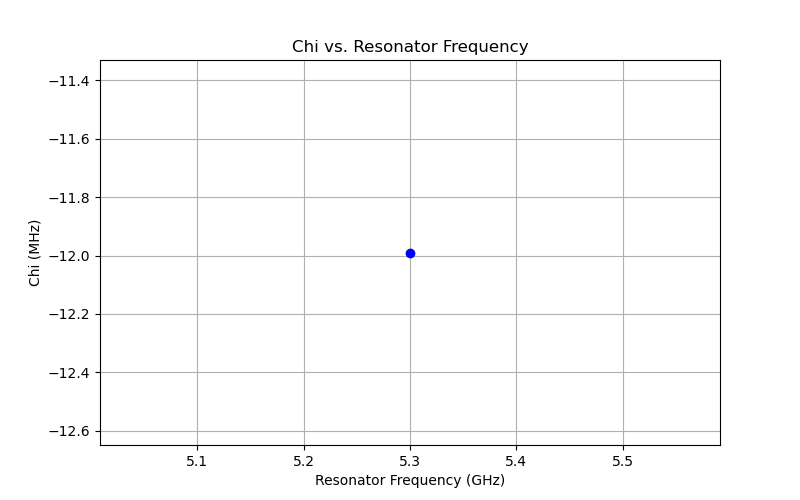

In [32]:
#Previous method I used  following Sean and Darios calculation borrowed from Fluxonium analysis

EC = .22
EJ = .22*110
n_g_con = 2 * (2 * EC / EJ) ** 0.25
g_a = 0.120 

# Sweep range for resonator frequency
resonator_freqs = np.linspace(5.3,8, 1)  # GHz
chi_values = []

# Loop over resonator frequencies
for E_osc in resonator_freqs:
    qbtA = scq.Transmon(
    EJ=EJ,      # Josephson energy
    EC=EC,      # Charging energy
    ng=0.3,     # Offset charge
    ncut=41,    # Charge basis cutoff
    truncated_dim=10  # Number of levels to keep
)
    
    # Define resonator
    qbtA_ro = scq.Oscillator(E_osc=E_osc, truncated_dim=20)
    bare_states_A = qbtA.eigenvals()-qbtA.eigenvals()[0]
    # Define Hilbert space
    hilbertspace = scq.HilbertSpace([qbtA, qbtA_ro])
    
    # Compute bare states
    hilbertspace.add_interaction(g=g_a, op1=qbtA.n_operator, op2=qbtA_ro.creation_operator, add_hc=True)
    
    # Generate spectrum lookup table
    hilbertspace.generate_lookup()
    
    # Extract eigenvalues
    evals = hilbertspace["evals"][0]
    diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims] * 2)
    )
    
    # Truncate Hamiltonian
    total_truncation = 60
    def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
        return qt.Qobj(operator[:dimension, :dimension])
    
    diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)
    evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28
    
    # Compute chi
    e_11 = evalues[hilbertspace.dressed_index((1,1))]
    e_10 = evalues[hilbertspace.dressed_index((1,0))]
    e_01 = evalues[hilbertspace.dressed_index((0,1))]
    e_00 = evalues[hilbertspace.dressed_index((0,0))]
    
    chi = e_11 - e_10 - e_01 + e_00

    print(chi*1000, "Chi (MHz)")
    chi_values.append(chi * 1000)  # Convert to MHz

# Plot chi vs. resonator frequency
plt.figure(figsize=(8, 5))
plt.plot(resonator_freqs, chi_values, marker='o', linestyle='-', color='b')
plt.xlabel("Resonator Frequency (GHz)")
plt.ylabel("Chi (MHz)")
plt.title("Chi vs. Resonator Frequency")
plt.grid(True)
plt.show()



In [33]:
# new add interaction method for transmon and resonator from scqubits. 
EC = 0.22
EJ = 0.22 * 110
E_osc = 5.3  # GHz, resonator frequency

tmon = scq.Transmon(
    EJ=EJ,      # Josephson energy
    EC=EC,      # Charging energy
    ng=0.3,     # Offset charge
    ncut=41,    # Charge basis cutoff
    truncated_dim=10  # Number of levels to keep
)


resonator = scq.Oscillator(E_osc=E_osc, truncated_dim=20)

hilbertspace = scq.HilbertSpace([tmon, resonator])

g = -0.120*1j

hilbertspace.add_interaction(
    expr="g * n * a - g * n * adag",
    op1=("n", tmon.n_operator),
    op2=("adag", resonator.creation_operator),
    op3 = ("a", resonator.annihilation_operator),
    add_hc=False
)

hilbertspace.generate_lookup()
    
    # Extract eigenvalues
evals = hilbertspace["evals"][0]
diag_dressed_hamiltonian = (
    2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims] * 2)
    )

total_truncation = 10
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
        return qt.Qobj(operator[:dimension, :dimension])
    
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)
evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28
    
    # Compute chi
e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
    
chi = e_11 - e_10 - e_01 + e_00

# ...existing code...

print(f"{chi*1000:.4f} Chi (MHz)")

print(f"{e_11:.4f}, {e_10:.4f}, {e_01:.4f}, {e_00:.4f} Energies (GHz) for (11, 10, 01, 00) states")
detuning = e_10 - e_01
print(f"{detuning:.4f} Detuning (GHz)")

# ...existing code...

Chi = abs(chi)

-11.9895 Chi (MHz)
11.5876, 6.3243, 5.2753, 0.0000 Energies (GHz) for (11, 10, 01, 00) states
1.0491 Detuning (GHz)


 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: overflow encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: invalid value encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199

1.2220000000000004

In [34]:
floquet_analysis = ft.FloquetAnalysis(
    model, state_indices=state_indices, options=options
)
data_vals = floquet_analysis.run(filepath=filepath)

Running floquet simulation with parameters: 
model: H0: Quantum object: dims=[[20], [20]], shape=(20, 20), type='oper', dtype=Dense, isherm=True
Qobj data =
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          39.57205332   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          77.63717533   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         114.09075022   0.
    0.           0.           0.           0.    

In [35]:
# All of the data is saved in data_vals above, but we can also recover the data from
# file as shown here.
_, new_data_dict = ft.read_from_file(filepath)

## Branch analysis

Using the Blais branch analysis, we can identify which states are responsible for the two transitions identified above. In this analysis we track the Floquet modes step-by-step from zero drive amplitude up to the largest drive amplitude we care about. We do this by computing overlaps of the new Floquet modes with those from the previous amplitude step. Thus there is no need to worry about the "ideal displaced state": the states are automatically tracked.

Having tracked and identified the Floquet modes (and associated quasienergies), we compute the average excitation number for each branch $\ell$: $N_{t}(\ell)=\sum_{j}j|\langle j\widetilde{|\ell\rangle}|^2$, where $|j\rangle$ are the undriven eigenstates and $\widetilde{|\ell\rangle}$ is the Floquet mode assigned to branch $\ell$. These Floquet modes are themselves a function of drive amplitude and frequency, leading to the branch plots below.

For more details on the theory, please see [Dumas et al, arXiv (2024)](https://arxiv.org/abs/2402.06615), [Shillito et al, PR Applied (2022)](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.18.034031)

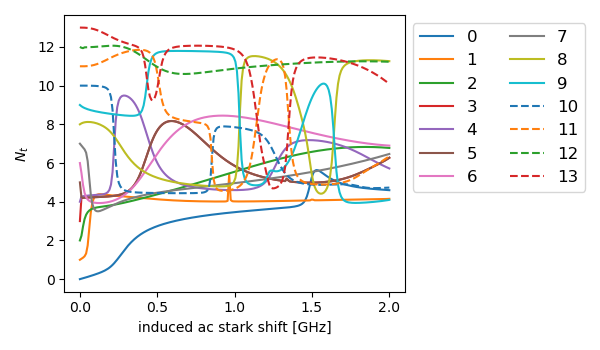

In [36]:
%matplotlib widget
omega_d_idx = 0  # index for the first drive frequency
chi = 0.08 
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim-6), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("induced ac stark shift [GHz]")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("branch_analysis.pdf")
plt.show()

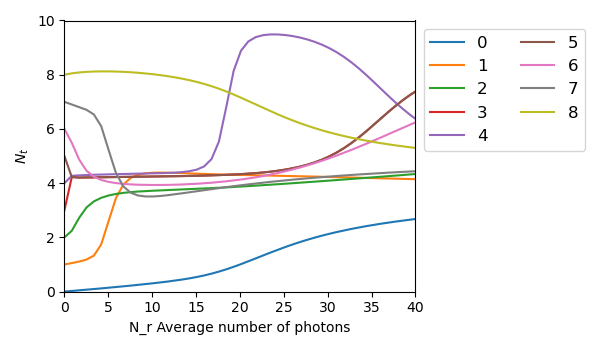

In [41]:
omega_d_idx = 0  # index for the first drive frequency
chi = 0.0079579 
chi = 0.012
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim-11), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_values / Chi / 2 / np.pi,
        new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("N_r Average number of photons")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0, 10)  # Adjust x-axis limit for clarity
ax.set_xlim(0, 40)  # Adjust x-axis limit for clarity
plt.tight_layout()
plt.savefig("branch_analysis.pdf")
plt.show()

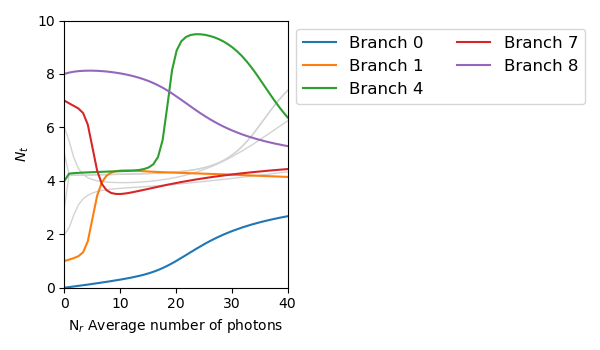

In [44]:
omega_d_idx = 0  # index for the first drive frequency

highlight = [0, 1, 4, 7, 8]  # branches to highlight
n_branches = 9  # total number of branches

cycler_iter = iter(color_ls_alpha_cycler)

fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx in range(n_branches):
    if curve_idx in highlight:
        sty = next(cycler_iter)
        ax.plot(
            chi_ac_values / Chi / 2 / np.pi,
            new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
            label=f"Branch {curve_idx}",
            **sty,
        )
    else:
        ax.plot(
            chi_ac_values / Chi / 2 / np.pi,
            new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
            color="lightgray",
            linewidth=1,
            label=None,
            zorder=0,
        )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("N$_r$ Average number of photons")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0, 10)
ax.set_xlim(0, 40)
plt.tight_layout()
plt.savefig("branch_analysis.pdf")
plt.show()

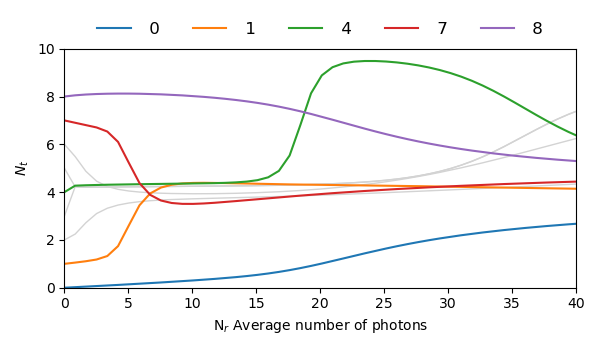

In [47]:
omega_d_idx = 0  # index for the first drive frequency

highlight = [0, 1, 4, 7, 8]  # branches to highlight
n_branches = 9  # total number of branches

cycler_iter = iter(color_ls_alpha_cycler)

fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx in range(n_branches):
    if curve_idx in highlight:
        sty = next(cycler_iter)
        ax.plot(
            chi_ac_values / Chi / 2 / np.pi,
            new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
            label=f" {curve_idx}",
            **sty,
        )
    else:
        ax.plot(
            chi_ac_values / Chi / 2 / np.pi,
            new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
            color="lightgray",
            linewidth=1,
            label=None,
            zorder=0,
        )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("N$_r$ Average number of photons")
ax.set_ylim(0, 10)
ax.set_xlim(0, 40)
# Place the legend above the plot in a single row
ax.legend(
    fontsize=12, ncol=len(highlight), loc="lower center",
    bbox_to_anchor=(0.5, 1.02), borderaxespad=0, frameon=False
)
plt.tight_layout()
plt.savefig("branch_analysis.pdf")
plt.show()

We see that the branch with an average excitation number of 1 experiences two branch crossing events. The first is slightly above $\chi_{\rm ac}=0.04$ GHz and is with the fifth excited state. The second is at $\chi_{\rm ac}=0.08$ GHz and is with the 13th excited state. Note that the first-excited-state branch swaps with the fifth-excited-state branch after the first branch crossing: it is the fifth-excited state branch that now has an average excitation number of nearly 1 and should be identified with the first-excited state. Put another way: if in a readout experiment one approached this resonance too slowly, the first excited state would ionize up to the fifth excited transmon state.

These two techniques are thus complementary for investigating ionization. The displaced-state technique allows us to get an overall view of the landscape of resonances, while the branch-crossing technique allows us to investigate which states are responsible for the resonances. They also helpfully provide a check on one another: aside from the computation of the Floquet modes themselves, they are computed in totally different manners.

Its nice to verify that the $\chi_{\rm ac}$ we think we are inducing on the transmon is the actual induced $\chi_{\rm ac}$ as extracted from the change in quasienergy differences.

We see that for small $\chi_{\rm ac}$, the induced $\chi_{\rm ac}$ and the predicted $\chi_{\rm ac}$ are bang on. The quasienergies are tracked using the Blais state-tracking technique, which is why we see the deviation beginning at $\chi_{\rm ac}=0.04$ GHz due to the branch crossing that occurs at that location.

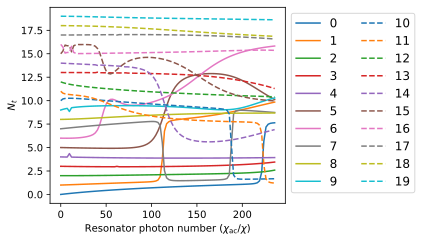

In [54]:
# ...existing code...

chi_fixed = .04  # Example: chi/2pi = 2 MHz, so chi_fixed in rad/s

fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_values / chi_fixed,
        new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("Resonator photon number ($\chi_{\mathrm{ac}}/\chi$)")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("branch_analysis_photon_number.pdf")
plt.show()
# ...existing code...